# WiseNET evaluation plots

This notebook loads the JSON evaluation files in `evaluations/` and generates plots to visualise detection quality (presence metrics, localisation, timing, and probabilistic smoothing effects).

This notebook was created with AI assistance for scaffolding and then reviewed/edited to match the project requirements.

Outputs are written to:

- `evaluations/plots/` (PNG and SVG)

Run cells top-to-bottom. The final cell regenerates all plots in one go.


## Notebook outline

1. Import & configure plotting
2. Load evaluation JSON files into pandas
3. Normalise metrics into a tidy DataFrame
4. Master table viewer (filters + sanity checks)
5. Presence metrics bar charts (Precision/Recall/F1)
6. Localisation charts (mIoU and IoU>=0.5)
7. Classification quality charts (Accuracy, Balanced Accuracy, MCC)
8. Entry/exit timing visualisation (frames relative to GT)
9. Probabilistic smoothing effect (delta plots: On − Off)
10. Automatic detectors vs manual GT (benchmark plots)
11. Optional: per-video prediction presence timeline
12. Save-all helper (PNG/SVG, deterministic filenames)
13. VS Code friendly runner cell (regenerate all plots)


In [ ]:
from __future__ import annotations

import json
import math
import re
from dataclasses import dataclass
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np

try:
    import pandas as pd
except ModuleNotFoundError as exc:
    raise ModuleNotFoundError(
        "Missing dependency: pandas. Install with: pip install pandas"
    ) from exc

try:
    import seaborn as sns
except ModuleNotFoundError as exc:
    raise ModuleNotFoundError(
        "Missing dependency: seaborn. Install with: pip install seaborn"
    ) from exc

# Robust path handling: the notebook may run from project root or from within ./evaluations
_cwd = Path.cwd()
PROJECT_ROOT = _cwd.parent if _cwd.name.lower() == "evaluations" else _cwd
EVALUATIONS_DIR = PROJECT_ROOT / "evaluations"
PLOTS_DIR = EVALUATIONS_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

FIG_DPI = 140
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = FIG_DPI
plt.rcParams["savefig.dpi"] = FIG_DPI


def savefig(fig: plt.Figure, name: str) -> Path:
    assert name, "name must be non-empty"
    safe = re.sub(r"[^a-zA-Z0-9._-]+", "_", name).strip("_")
    assert safe, "sanitised filename empty"

    lower = name.lower()
    category = "our_vs_manual"
    if lower.startswith("auto_detectors_vs_manual") or lower.startswith("benchmark_dnn_vs_industry") or lower.startswith("quality_"):
        category = "auto_vs_manual"
    elif "vs_auto" in lower:
        category = "our_vs_auto"

    is_option_a = "option_a" in lower
    leaf = "option_a" if is_option_a else "expanded"
    if "prob_smoothing_deltas" in lower:
        leaf = "option_a_prob" if is_option_a else "expanded_prob"

    out_dir = PLOTS_DIR / category / leaf
    out_dir.mkdir(parents=True, exist_ok=True)

    png_path = out_dir / f"{safe}.png"
    svg_path = out_dir / f"{safe}.svg"

    fig.tight_layout()
    fig.savefig(png_path)
    fig.savefig(svg_path)
    print(f"Wrote: {png_path}")
    print(f"Wrote: {svg_path}")
    return png_path


def derived_metrics(tp: int, fp: int, fn: int, tn: int) -> dict[str, float]:
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total if total else 0.0

    recall = tp / (tp + fn) if (tp + fn) else 0.0
    specificity = tn / (tn + fp) if (tn + fp) else 0.0
    balanced_accuracy = (recall + specificity) / 2.0

    denom = math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mcc = ((tp * tn) - (fp * fn)) / denom if denom else 0.0

    return {
        "accuracy": float(accuracy),
        "specificity": float(specificity),
        "balanced_accuracy": float(balanced_accuracy),
        "mcc": float(mcc),
    }


def load_metrics(path: Path) -> dict[str, Any]:
    assert path.exists(), f"Metrics file not found: {path}"
    payload = json.loads(path.read_text(encoding="utf-8"))
    assert isinstance(payload, dict), "metrics JSON must be an object"
    assert "aggregate" in payload, "metrics JSON missing aggregate"
    return payload


@dataclass(frozen=True)
class ParsedName:
    pipeline: str
    gt: str
    prob: str
    split: str


def parse_metrics_filename(filename: str) -> ParsedName:
    # Examples:
    # - metrics_hog_vs_manual.json
    # - metrics_dnn_vs_manual_prob.json
    # - metrics_hog_vs_manual_option_a.json
    # - metrics_dnn_vs_auto_ssd512_prob.json
    # - metrics_auto_yolov3_vs_manual.json
    name = filename
    name = name.removeprefix("metrics_")
    name = name.removesuffix(".json")

    prob = "off"
    if name.endswith("_prob"):
        prob = "on"
        name = name[: -len("_prob")]

    split = "expanded"
    if name.endswith("_option_a"):
        split = "option_a"
        name = name[: -len("_option_a")]

    # Dataset-provided auto detectors (pipeline starts with auto_)
    if name.startswith("auto_"):
        pipeline, gt = name.split("_vs_", 1)
        return ParsedName(pipeline=pipeline, gt=gt, prob="n/a", split=split)

    pipeline, gt = name.split("_vs_", 1)
    return ParsedName(pipeline=pipeline, gt=gt, prob=prob, split=split)


def aggregate_row(path: Path) -> dict[str, Any]:
    metrics = load_metrics(path)
    agg = metrics["aggregate"]
    parsed = parse_metrics_filename(path.name)

    tp = int(agg.get("tp", 0))
    fp = int(agg.get("fp", 0))
    fn = int(agg.get("fn", 0))
    tn = int(agg.get("tn", 0))
    d = derived_metrics(tp=tp, fp=fp, fn=fn, tn=tn)

    row: dict[str, Any] = {
        "file": path.name,
        "path": str(path),
        "pipeline": parsed.pipeline,
        "gt": parsed.gt,
        "prob": parsed.prob,
        "split": parsed.split,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn,
        "precision": float(agg.get("precision", 0.0)),
        "recall": float(agg.get("recall", 0.0)),
        "f1": float(agg.get("f1", 0.0)),
        "mean_iou": float(agg.get("mean_iou", 0.0)),
        "iou_ge_0_5": float(agg.get("iou_50_rate", 0.0)),
        "entry_detected_rate": float(agg.get("entry_detected_rate", 0.0) or 0.0),
        "exit_detected_rate": float(agg.get("exit_detected_rate", 0.0) or 0.0),
        "entry_latency_frames_mean": agg.get("entry_latency_frames_mean"),
        "exit_latency_frames_mean": agg.get("exit_latency_frames_mean"),
        "accuracy": d["accuracy"],
        "specificity": d["specificity"],
        "balanced_accuracy": d["balanced_accuracy"],
        "mcc": d["mcc"],
    }

    return row


METRICS_GLOB = "metrics_*.json"
METRICS_DIR = EVALUATIONS_DIR / "metrics"
metrics_paths = sorted(METRICS_DIR.rglob(METRICS_GLOB))
print(f"Found {len(metrics_paths)} metrics files under: {METRICS_DIR}")
for p in metrics_paths:
    print("-", p.name)

rows = [aggregate_row(p) for p in metrics_paths]
df = pd.DataFrame(rows)

required_cols = {
    "pipeline",
    "gt",
    "prob",
    "split",
    "precision",
    "recall",
    "f1",
    "mean_iou",
    "iou_ge_0_5",
    "accuracy",
    "balanced_accuracy",
    "mcc",
}
missing_cols = sorted(required_cols - set(df.columns))
if missing_cols:
    raise KeyError(f"Missing required columns: {missing_cols}")

# Long-form for easy seaborn plots
metric_cols = [
    "precision",
    "recall",
    "f1",
    "mean_iou",
    "iou_ge_0_5",
    "accuracy",
    "balanced_accuracy",
    "mcc",
]

df_long = df.melt(
    id_vars=["pipeline", "gt", "prob", "split", "file"],
    value_vars=metric_cols,
    var_name="metric",
    value_name="value",
)

print("\nCompact view:")
print(
    df[["split", "gt", "pipeline", "prob", "precision", "recall", "f1", "mean_iou", "iou_ge_0_5"]]
    .sort_values(["split", "gt", "pipeline", "prob"])
    .to_string(index=False)
 )

Found 17 metrics files under: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations
- metrics_auto_hogsvm_vs_manual.json
- metrics_auto_ssd512_vs_manual.json
- metrics_auto_yolov3_vs_manual.json
- metrics_dnn_vs_auto_ssd512.json
- metrics_dnn_vs_auto_ssd512_prob.json
- metrics_dnn_vs_auto_yolov3.json
- metrics_dnn_vs_auto_yolov3_prob.json
- metrics_dnn_vs_manual.json
- metrics_dnn_vs_manual_option_a.json
- metrics_dnn_vs_manual_option_a_prob.json
- metrics_dnn_vs_manual_prob.json
- metrics_hog_vs_auto_hogsvm.json
- metrics_hog_vs_auto_hogsvm_prob.json
- metrics_hog_vs_manual.json
- metrics_hog_vs_manual_option_a.json
- metrics_hog_vs_manual_option_a_prob.json
- metrics_hog_vs_manual_prob.json

Compact view:
   split          gt    pipeline prob  precision   recall       f1  mean_iou  iou_ge_0_5
expanded auto_hogsvm         hog  off   0.627795 0.592711 0.609748  0.231341    0.015000
expanded auto_hogsvm         hog   on   0.637652 0.580714 0.607852  0.152166 

In [2]:
def view_master_table(*, gt: str | None = None, split: str | None = None, prob: str | None = None) -> pd.DataFrame:
    out = df.copy()
    if gt is not None:
        out = out[out["gt"] == gt]
    if split is not None:
        out = out[out["split"] == split]
    if prob is not None:
        out = out[out["prob"] == prob]

    cols = [
        "split",
        "gt",
        "pipeline",
        "prob",
        "precision",
        "recall",
        "f1",
        "mean_iou",
        "iou_ge_0_5",
        "entry_latency_frames_mean",
        "exit_latency_frames_mean",
        "accuracy",
        "balanced_accuracy",
        "mcc",
        "file",
    ]
    cols = [c for c in cols if c in out.columns]
    return out[cols].sort_values(["split", "gt", "pipeline", "prob"])


# Quick sanity checks
print("Rows:", len(df))
print("Unique pipelines:", sorted(df["pipeline"].unique().tolist()))
print("Unique GTs:", sorted(df["gt"].unique().tolist()))
print("Unique splits:", sorted(df["split"].unique().tolist()))
print("Unique prob states:", sorted(df["prob"].unique().tolist()))

print("\nManual GT (expanded) view:")
print(view_master_table(gt="manual", split="expanded").to_string(index=False))


Rows: 17
Unique pipelines: ['auto_hogsvm', 'auto_ssd512', 'auto_yolov3', 'dnn', 'hog']
Unique GTs: ['auto_hogsvm', 'auto_ssd512', 'auto_yolov3', 'manual']
Unique splits: ['expanded', 'option_a']
Unique prob states: ['n/a', 'off', 'on']

Manual GT (expanded) view:
   split     gt    pipeline prob  precision   recall       f1  mean_iou  iou_ge_0_5  entry_latency_frames_mean  exit_latency_frames_mean  accuracy  balanced_accuracy       mcc                               file
expanded manual auto_hogsvm  n/a   0.867426 0.328767 0.476815  0.528865    0.740686                 149.142857               -132.928571  0.313038           0.164384 -0.298309 metrics_auto_hogsvm_vs_manual.json
expanded manual auto_ssd512  n/a   0.997008 0.786347 0.879235  0.728031    0.956529                  34.000000                -60.285714  0.784496           0.393174 -0.025284 metrics_auto_ssd512_vs_manual.json
expanded manual auto_yolov3  n/a   0.996658 0.772303 0.870253  0.754409    0.974144                   2

In [ ]:
# --- CELL A: DATASET CLASS BALANCE (Precision inflation check) ---
def plot_class_balance(*, split_name: str = "expanded") -> Path | None:
    """
    Visualises the ratio of Positive (Person) vs Negative (Empty) frames.
    Requires: evaluations/meta/class_balance.json

    Notes on file format:
    - Current repo format: {"videos": [...], "aggregate": {"positive_frames": ..., "negative_frames": ...}}
    - Legacy/alternative format support: {"expanded": {"pos":..., "neg":...}, ...}
    """
    path = EVALUATIONS_DIR / "meta" / "class_balance.json"
    if not path.exists():
        print(f"Missing file: {path}")
        return None

    payload = json.loads(path.read_text(encoding="utf-8"))

    pos: int | None = None
    neg: int | None = None

    if isinstance(payload, dict) and "aggregate" in payload and isinstance(payload["aggregate"], dict):
        agg = payload["aggregate"]
        pos = int(agg.get("positive_frames", 0))
        neg = int(agg.get("negative_frames", 0))
        # This file represents whichever split was last analysed; keep split_name as a label only.
    elif isinstance(payload, dict) and split_name in payload and isinstance(payload[split_name], dict):
        counts = payload[split_name]
        pos = int(counts.get("pos", counts.get("positive_frames", 0)))
        neg = int(counts.get("neg", counts.get("negative_frames", 0)))
    else:
        print(f"Unrecognised class_balance.json schema. Keys: {sorted(payload.keys()) if isinstance(payload, dict) else type(payload)}")
        return None

    total = int(pos + neg)
    if total <= 0:
        print("class_balance.json has no frames to plot")
        return None

    labels = ["Positive frames\n(Person)", "Negative frames\n(Empty)"]
    values = [pos, neg]
    colours = ["#2ca02c", "#d62728"]

    fig, ax = plt.subplots(figsize=(6.5, 6.5))
    ax.pie(
        values,
        labels=labels,
        autopct="%1.1f%%",
        startangle=140,
        colors=colours,
        explode=(0.05, 0.0),
        textprops={"fontsize": 12, "weight": "bold"},
    )
    ax.set_title(
        f"Dataset composition ({split_name.replace('_', ' ').title()} split label)\nHigh negative rate can inflate precision",
        fontsize=13,
    )

    out = savefig(fig, f"class_balance_{split_name}")
    plt.close(fig)
    return out


print("Generated:", plot_class_balance(split_name="expanded"))

Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\class_balance_expanded.png
Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\class_balance_expanded.svg
Generated: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\class_balance_expanded.png


In [4]:
# --- CELL B: OUR DNN vs INDUSTRY GIANTS ---
def plot_dnn_vs_industry(*, split: str = "expanded") -> Path | None:
    """
    Compares our DNN (MobileNet-SSD) against WiseNET's Auto SSD_512 and Auto YOLOv3_608 (expanded split).
    Uses the already-loaded `df` from the earlier cells.
    """
    def _row(*, pipeline: str, prob: str, gt: str = "manual") -> dict[str, Any] | None:
        sub = df[
            (df["split"] == split)
            & (df["gt"] == gt)
            & (df["pipeline"] == pipeline)
            & (df["prob"] == prob)
        ]
        if len(sub) != 1:
            print(f"Missing/ambiguous row for split={split} gt={gt} pipeline={pipeline} prob={prob}: {len(sub)} rows")
            return None
        return sub.iloc[0].to_dict()

    models = {
        "Our MobileNet-SSD": _row(pipeline="dnn", prob="off"),
        "Auto SSD_512": _row(pipeline="auto_ssd512", prob="n/a"),
        "Auto YOLOv3_608": _row(pipeline="auto_yolov3", prob="n/a"),
    }
    models = {k: v for k, v in models.items() if v is not None}
    if not models:
        print("No data for industry comparison.")
        return None

    metric_keys = ["precision", "recall", "f1", "mean_iou"]
    metric_labels = ["Precision", "Recall", "F1 score", "Mean IoU"]

    x = np.arange(len(metric_keys))
    width = 0.25

    fig, ax = plt.subplots(figsize=(10.5, 6))
    for i, (name, row) in enumerate(models.items()):
        offset = width * (i - (len(models) - 1) / 2.0)
        vals = [float(row[m]) for m in metric_keys]
        ax.bar(x + offset, vals, width, label=name, alpha=0.9)

    ax.set_ylabel("Score (0.0 - 1.0)")
    ax.set_title("Benchmarking: our lightweight DNN vs heavyweight dataset detectors")
    ax.set_xticks(x, metric_labels)
    ax.set_ylim(0, 1.05)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.legend(loc="upper left", ncols=1)

    out = savefig(fig, f"benchmark_dnn_vs_industry_{split}")
    plt.close(fig)
    return out


print("Generated:", plot_dnn_vs_industry(split="expanded"))

Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\benchmark_dnn_vs_industry_expanded.png
Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\benchmark_dnn_vs_industry_expanded.svg
Generated: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\benchmark_dnn_vs_industry_expanded.png


In [5]:
# --- CELL C: SPLIT ROBUSTNESS CHECK ---
def plot_split_comparison_for_our_dnn(*, gt: str = "manual", prob: str = "off") -> Path | None:
    """
    Compares Our DNN performance on Option A vs Expanded splits.
    Uses the already-loaded `df` from the earlier cells.
    """
    def _row(*, split: str) -> dict[str, Any] | None:
        sub = df[
            (df["split"] == split)
            & (df["gt"] == gt)
            & (df["pipeline"] == "dnn")
            & (df["prob"] == prob)
        ]
        if len(sub) != 1:
            print(f"Missing/ambiguous row for split={split} gt={gt} pipeline=dnn prob={prob}: {len(sub)} rows")
            return None
        return sub.iloc[0].to_dict()

    splits = {
        "Option A (Balanced)": _row(split="option_a"),
        "Expanded (Full)": _row(split="expanded"),
    }
    splits = {k: v for k, v in splits.items() if v is not None}
    if not splits:
        print("No data available for split comparison.")
        return None

    metrics = ["precision", "recall", "mean_iou"]
    labels = [m.replace("_", " ").title() for m in metrics]
    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8.5, 5))
    for i, (name, row) in enumerate(splits.items()):
        vals = [float(row[m]) for m in metrics]
        ax.bar(x + (i * width), vals, width, label=name, alpha=0.85)

    ax.set_ylabel("Score")
    ax.set_title("Robustness check: impact of test split composition (Our DNN)")
    ax.set_xticks(x + width / 2.0, labels)
    ax.set_ylim(0, 1.0)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.legend()

    out = savefig(fig, f"split_robustness_check_dnn_{gt}_prob_{prob}")
    plt.close(fig)
    return out


print("Generated:", plot_split_comparison_for_our_dnn(gt="manual", prob="off"))

Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\split_robustness_check_dnn_manual_prob_off.png
Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\split_robustness_check_dnn_manual_prob_off.svg
Generated: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\split_robustness_check_dnn_manual_prob_off.png


Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\iou_comparison_expanded_manual_prob_off.png
Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\iou_comparison_expanded_manual_prob_off.svg
Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\iou_comparison_option_a_manual_prob_off.png
Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\iou_comparison_option_a_manual_prob_off.svg
Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\prf1_expanded_manual_prob_off.png
Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\prf1_expanded_manual_prob_off.svg
Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\localisation_miou_expanded_manual_prob_off.png
Wrote: e:\22837352\Media-Technology-Module\c

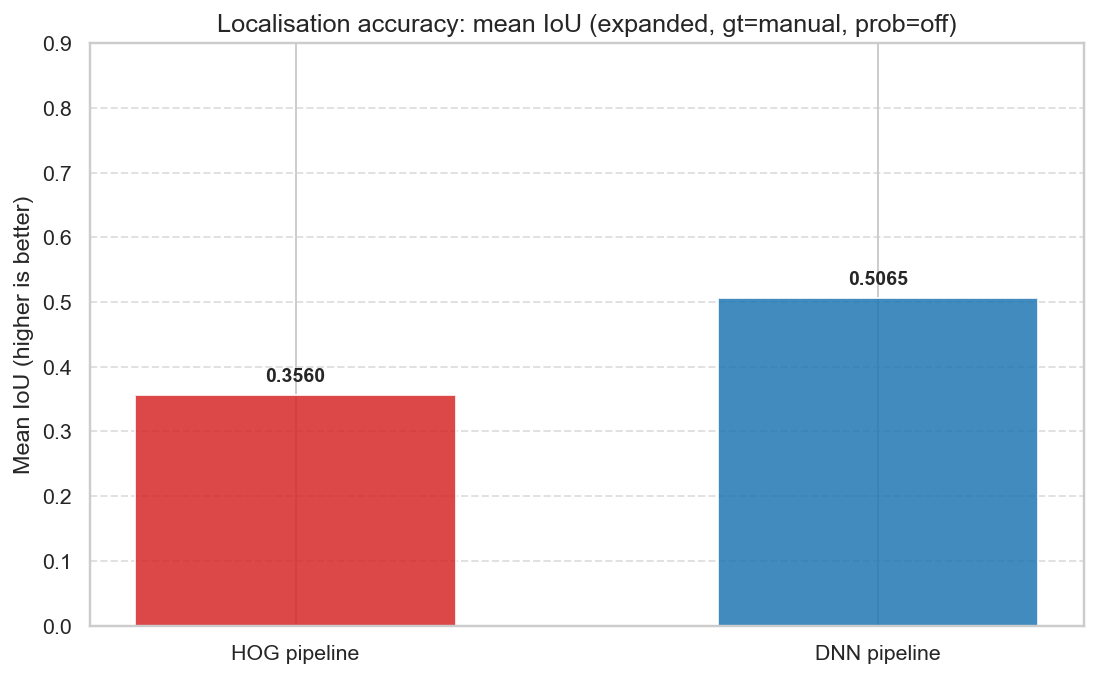

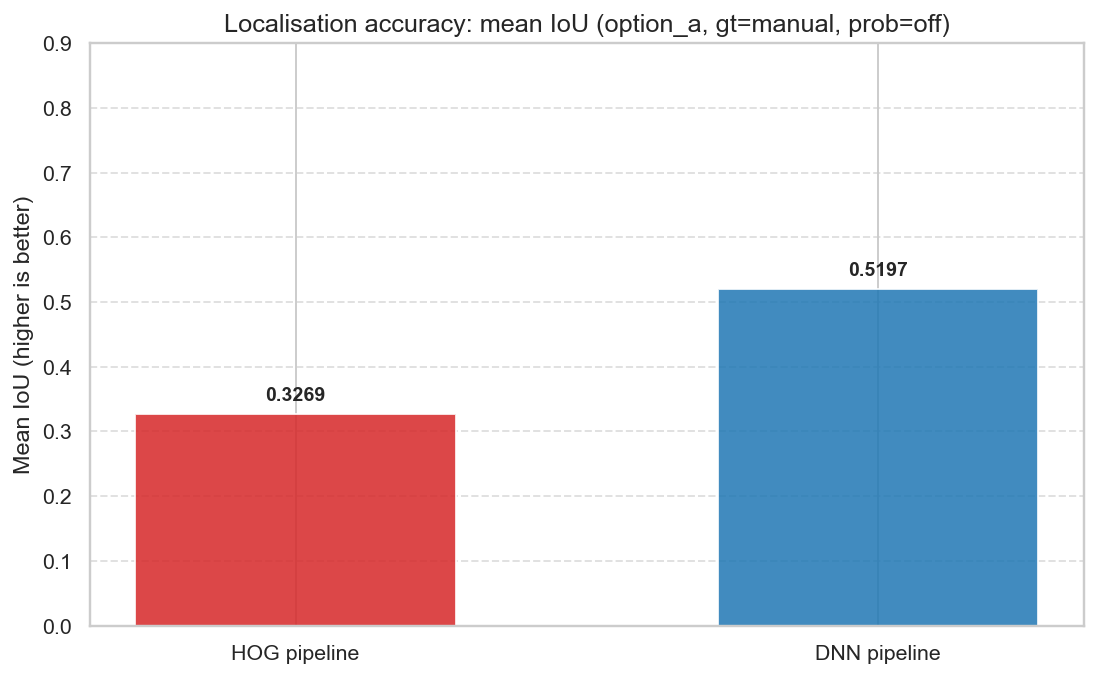

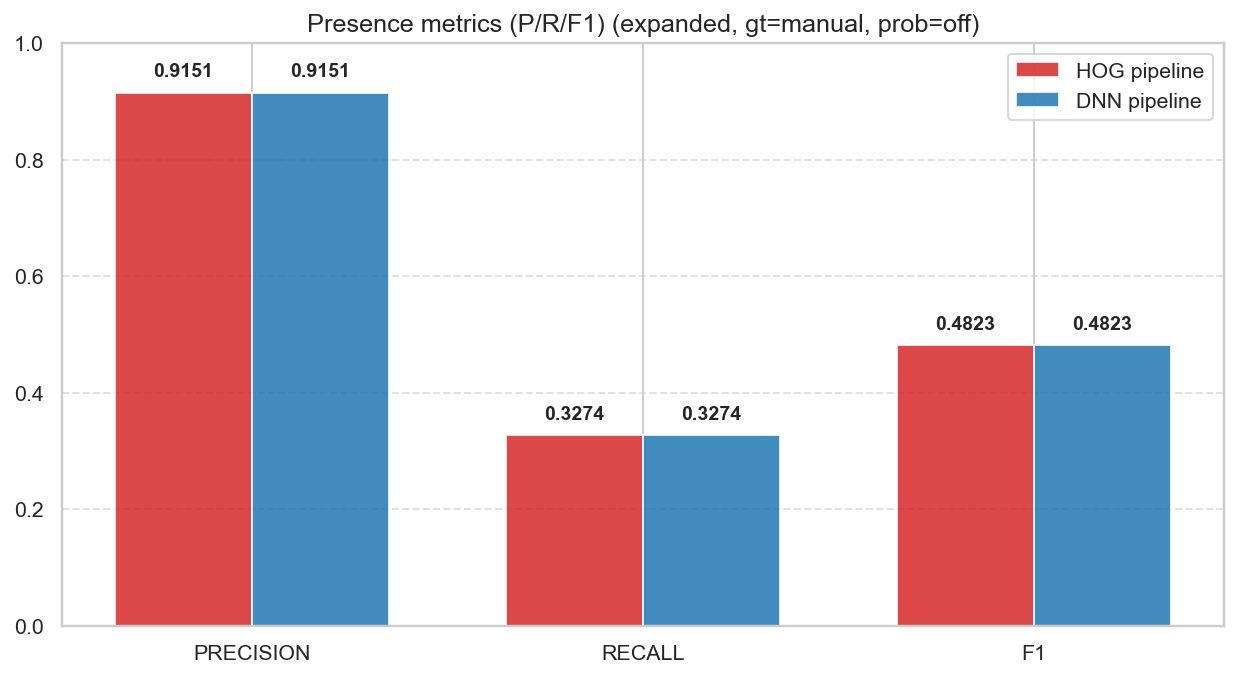

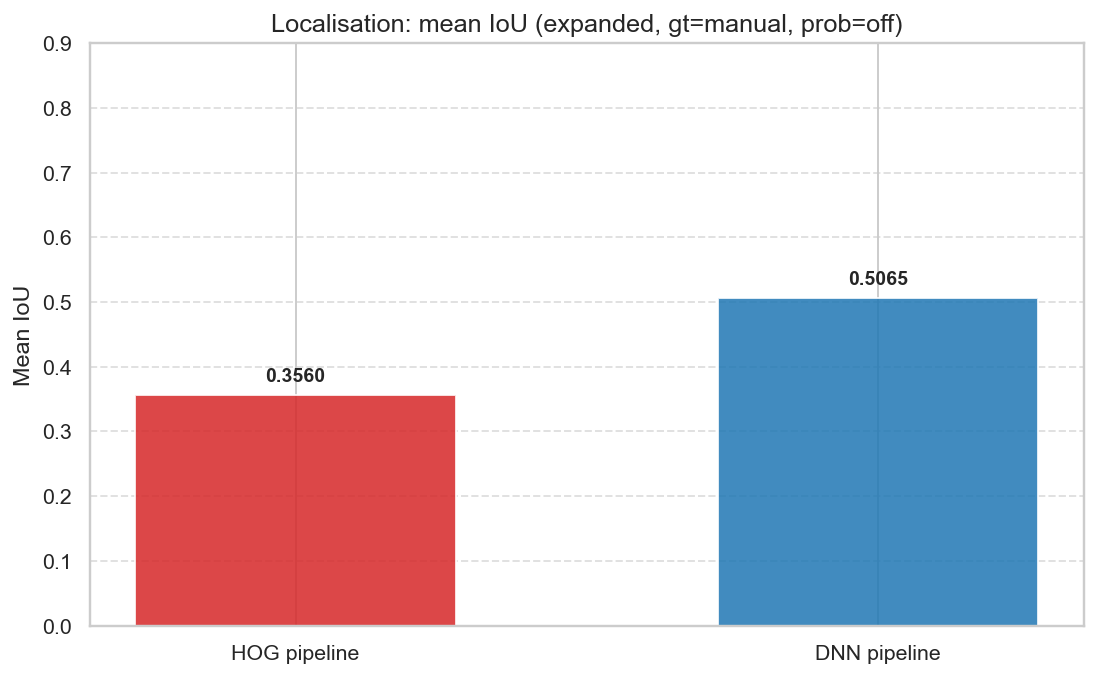

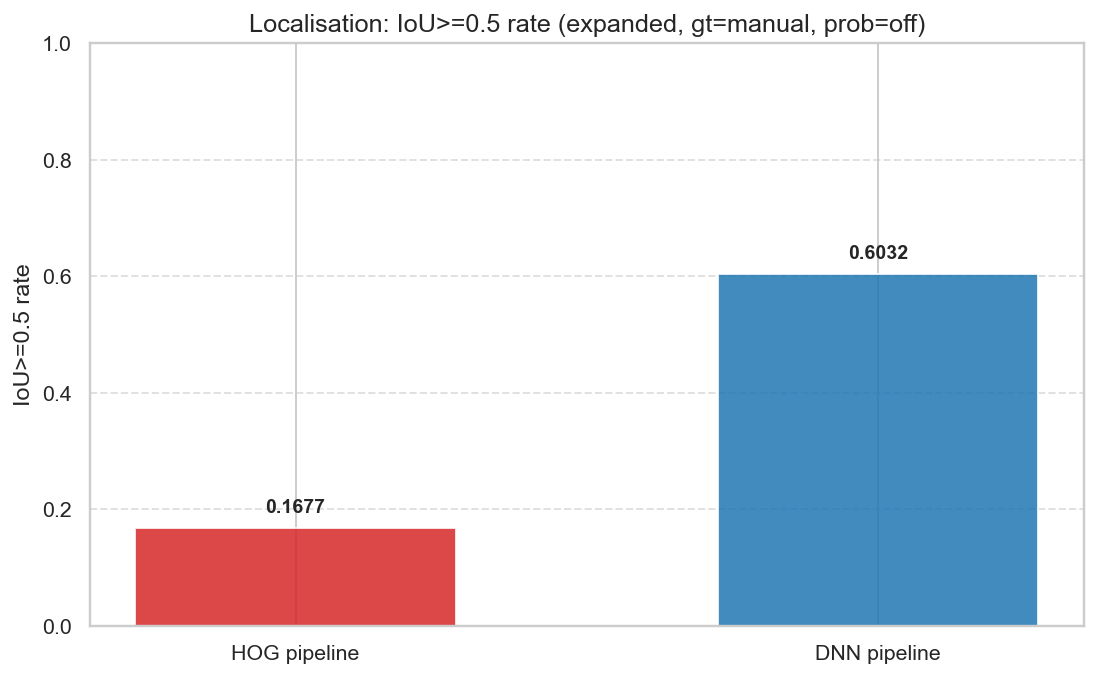

In [6]:
def _label_bars(ax: plt.Axes, bars, *, fmt: str = "{:.4f}", pad: float = 0.01) -> None:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + pad,
            fmt.format(height),
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )


def plot_iou_comparison(*, split: str, prob: str, gt: str = "manual") -> Path:
    sub = df[(df["gt"] == gt) & (df["split"] == split) & (df["prob"] == prob)]
    sub = sub[sub["pipeline"].isin(["hog", "dnn"])].sort_values("pipeline")
    assert len(sub) == 2, f"Expected 2 rows (hog,dnn) for gt={gt} split={split} prob={prob}; got {len(sub)}"

    models = ["HOG pipeline", "DNN pipeline"]
    iou_scores = [
        float(sub[sub["pipeline"] == "hog"]["mean_iou"].iloc[0]),
        float(sub[sub["pipeline"] == "dnn"]["mean_iou"].iloc[0]),
    ]

    colours = ["#d62728", "#1f77b4"]

    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(models, iou_scores, color=colours, alpha=0.85, width=0.55)
    ax.set_title(f"Localisation accuracy: mean IoU ({split}, gt={gt}, prob={prob})", fontsize=13)
    ax.set_ylabel("Mean IoU (higher is better)")
    ax.set_ylim(0, 0.9)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    _label_bars(ax, bars, pad=0.015)

    return savefig(fig, f"iou_comparison_{split}_{gt}_prob_{prob}")


def plot_prf1_grouped(*, split: str, prob: str, gt: str = "manual") -> Path:
    sub = df[(df["gt"] == gt) & (df["split"] == split) & (df["prob"] == prob)]
    sub = sub[sub["pipeline"].isin(["hog", "dnn"])].sort_values("pipeline")
    assert len(sub) == 2

    categories = ["precision", "recall", "f1"]
    hog_vals = [float(sub[sub["pipeline"] == "hog"][c].iloc[0]) for c in categories]
    dnn_vals = [float(sub[sub["pipeline"] == "dnn"][c].iloc[0]) for c in categories]

    x = np.arange(len(categories))
    width = 0.35

    fig, ax = plt.subplots(figsize=(9, 5))
    b1 = ax.bar(x - width / 2, hog_vals, width, label="HOG pipeline", color="#d62728", alpha=0.85)
    b2 = ax.bar(x + width / 2, dnn_vals, width, label="DNN pipeline", color="#1f77b4", alpha=0.85)

    ax.set_title(f"Presence metrics (P/R/F1) ({split}, gt={gt}, prob={prob})", fontsize=13)
    ax.set_xticks(x, [c.upper() for c in categories])
    ax.set_ylim(0, 1.0)
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.legend()

    _label_bars(ax, b1, pad=0.02)
    _label_bars(ax, b2, pad=0.02)

    return savefig(fig, f"prf1_{split}_{gt}_prob_{prob}")


def plot_localisation_pair(*, split: str, prob: str, gt: str = "manual") -> tuple[Path, Path]:
    sub = df[(df["gt"] == gt) & (df["split"] == split) & (df["prob"] == prob)]
    sub = sub[sub["pipeline"].isin(["hog", "dnn"])].sort_values("pipeline")
    assert len(sub) == 2

    models = ["HOG pipeline", "DNN pipeline"]
    miou = [
        float(sub[sub["pipeline"] == "hog"]["mean_iou"].iloc[0]),
        float(sub[sub["pipeline"] == "dnn"]["mean_iou"].iloc[0]),
    ]
    iou05 = [
        float(sub[sub["pipeline"] == "hog"]["iou_ge_0_5"].iloc[0]),
        float(sub[sub["pipeline"] == "dnn"]["iou_ge_0_5"].iloc[0]),
    ]

    colours = ["#d62728", "#1f77b4"]

    fig1, ax1 = plt.subplots(figsize=(8, 5))
    bars1 = ax1.bar(models, miou, color=colours, alpha=0.85, width=0.55)
    ax1.set_title(f"Localisation: mean IoU ({split}, gt={gt}, prob={prob})", fontsize=13)
    ax1.set_ylabel("Mean IoU")
    ax1.set_ylim(0, 0.9)
    ax1.grid(axis="y", linestyle="--", alpha=0.6)
    _label_bars(ax1, bars1, pad=0.015)
    p1 = savefig(fig1, f"localisation_miou_{split}_{gt}_prob_{prob}")

    fig2, ax2 = plt.subplots(figsize=(8, 5))
    bars2 = ax2.bar(models, iou05, color=colours, alpha=0.85, width=0.55)
    ax2.set_title(f"Localisation: IoU>=0.5 rate ({split}, gt={gt}, prob={prob})", fontsize=13)
    ax2.set_ylabel("IoU>=0.5 rate")
    ax2.set_ylim(0, 1.0)
    ax2.grid(axis="y", linestyle="--", alpha=0.6)
    _label_bars(ax2, bars2, pad=0.02)
    p2 = savefig(fig2, f"localisation_iou05_{split}_{gt}_prob_{prob}")

    return p1, p2


# Generate the sample-style plots requested
plot_iou_comparison(split="expanded", prob="off", gt="manual")
plot_iou_comparison(split="option_a", prob="off", gt="manual")
plot_prf1_grouped(split="expanded", prob="off", gt="manual")
plot_localisation_pair(split="expanded", prob="off", gt="manual")
plt.show()


Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\latency_expanded_manual_prob_off.png
Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\latency_expanded_manual_prob_off.svg


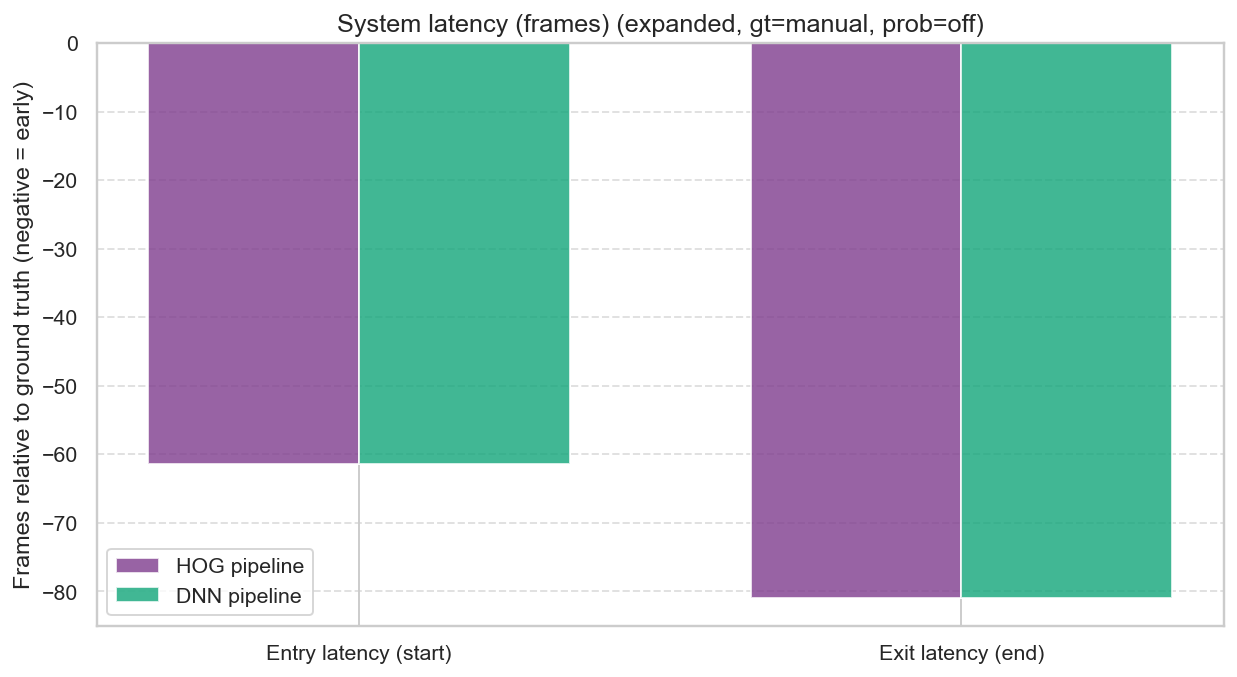

In [7]:
def plot_latency(*, split: str, prob: str, gt: str = "manual") -> Path:
    sub = df[(df["gt"] == gt) & (df["split"] == split) & (df["prob"] == prob)]
    sub = sub[sub["pipeline"].isin(["hog", "dnn"])].sort_values("pipeline")
    assert len(sub) == 2

    categories = ["Entry latency (start)", "Exit latency (end)"]

    hog_entry = float(sub[sub["pipeline"] == "hog"]["entry_latency_frames_mean"].iloc[0] or 0.0)
    hog_exit = float(sub[sub["pipeline"] == "hog"]["exit_latency_frames_mean"].iloc[0] or 0.0)
    dnn_entry = float(sub[sub["pipeline"] == "dnn"]["entry_latency_frames_mean"].iloc[0] or 0.0)
    dnn_exit = float(sub[sub["pipeline"] == "dnn"]["exit_latency_frames_mean"].iloc[0] or 0.0)

    x = np.arange(len(categories))
    width = 0.35

    fig, ax = plt.subplots(figsize=(9, 5))
    b1 = ax.bar(x - width / 2, [hog_entry, hog_exit], width, label="HOG pipeline", color="#7f3c8d", alpha=0.8)
    b2 = ax.bar(x + width / 2, [dnn_entry, dnn_exit], width, label="DNN pipeline", color="#11a579", alpha=0.8)

    ax.axhline(0, color="black", linewidth=1)
    ax.set_xticks(x, categories)
    ax.set_ylabel("Frames relative to ground truth (negative = early)")
    ax.set_title(f"System latency (frames) ({split}, gt={gt}, prob={prob})", fontsize=13)
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.6)

    return savefig(fig, f"latency_{split}_{gt}_prob_{prob}")


plot_latency(split="expanded", prob="off", gt="manual")
plt.show()


Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\quality_expanded_manual_prob_off.png
Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\quality_expanded_manual_prob_off.svg


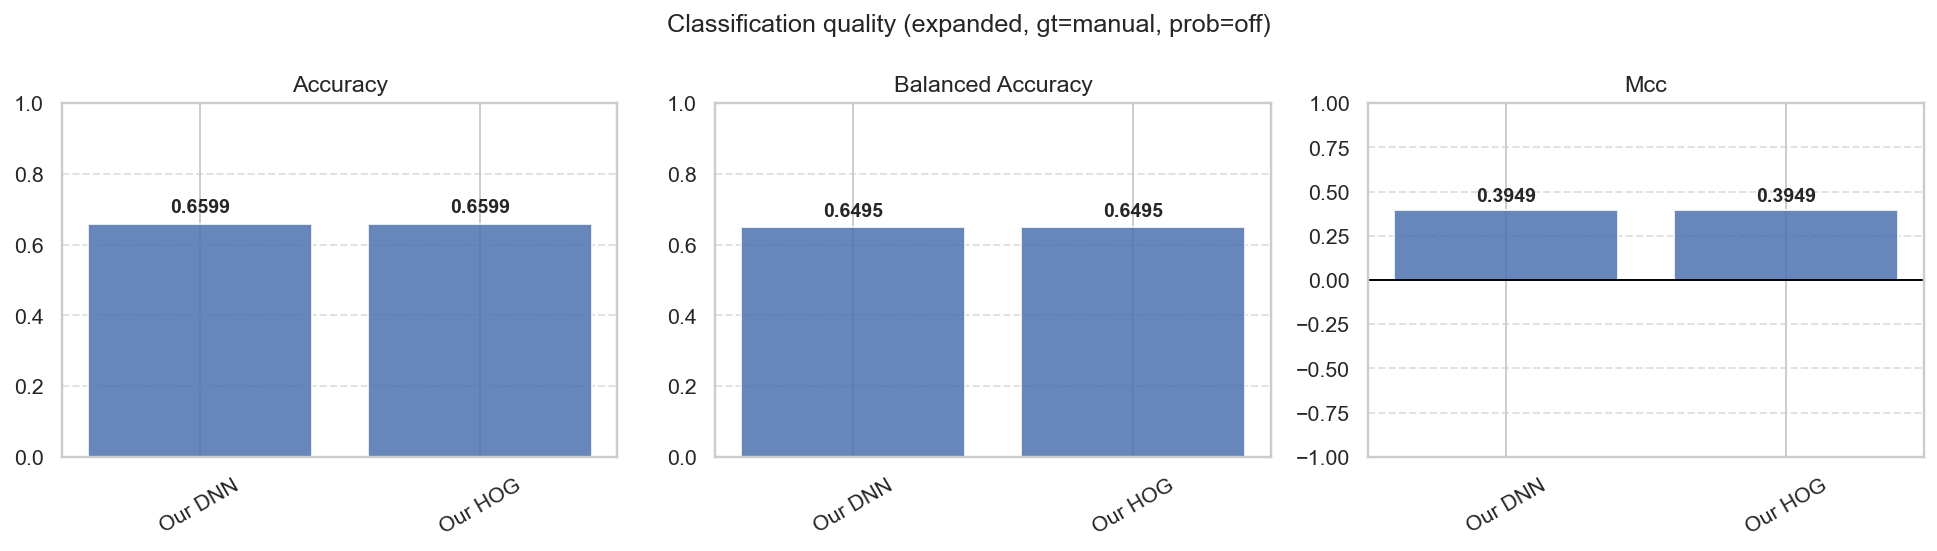

In [8]:
def plot_quality_metrics(*, split: str, prob: str, gt: str = "manual") -> Path:
    sub = df[(df["gt"] == gt) & (df["split"] == split) & (df["prob"] == prob)].copy()
    # Keep a small consistent set of pipelines where it makes sense
    keep = ["hog", "dnn", "auto_hogsvm", "auto_ssd512", "auto_yolov3"]
    sub = sub[sub["pipeline"].isin(keep)]
    assert len(sub) > 0

    sub["display"] = sub["pipeline"].map(
        {
            "hog": "Our HOG",
            "dnn": "Our DNN",
            "auto_hogsvm": "Auto HOG_SVM",
            "auto_ssd512": "Auto SSD_512",
            "auto_yolov3": "Auto YOLOv3_608",
        }
    )

    metrics = ["accuracy", "balanced_accuracy", "mcc"]
    fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=False)

    for ax, metric in zip(axes, metrics):
        sub_sorted = sub.sort_values("display")
        bars = ax.bar(sub_sorted["display"], sub_sorted[metric], alpha=0.85)
        ax.set_title(metric.replace("_", " ").title())
        if metric == "mcc":
            ax.axhline(0, color="black", linewidth=1)
        ax.set_ylim(-1.0 if metric == "mcc" else 0.0, 1.0)
        ax.grid(axis="y", linestyle="--", alpha=0.6)
        ax.tick_params(axis="x", rotation=30)
        _label_bars(ax, bars, pad=0.02 if metric != "mcc" else 0.03)

    fig.suptitle(f"Classification quality ({split}, gt={gt}, prob={prob})", fontsize=13)
    return savefig(fig, f"quality_{split}_{gt}_prob_{prob}")


plot_quality_metrics(split="expanded", prob="off", gt="manual")
plt.show()


Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\prob_smoothing_deltas_expanded_manual.png
Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\prob_smoothing_deltas_expanded_manual.svg


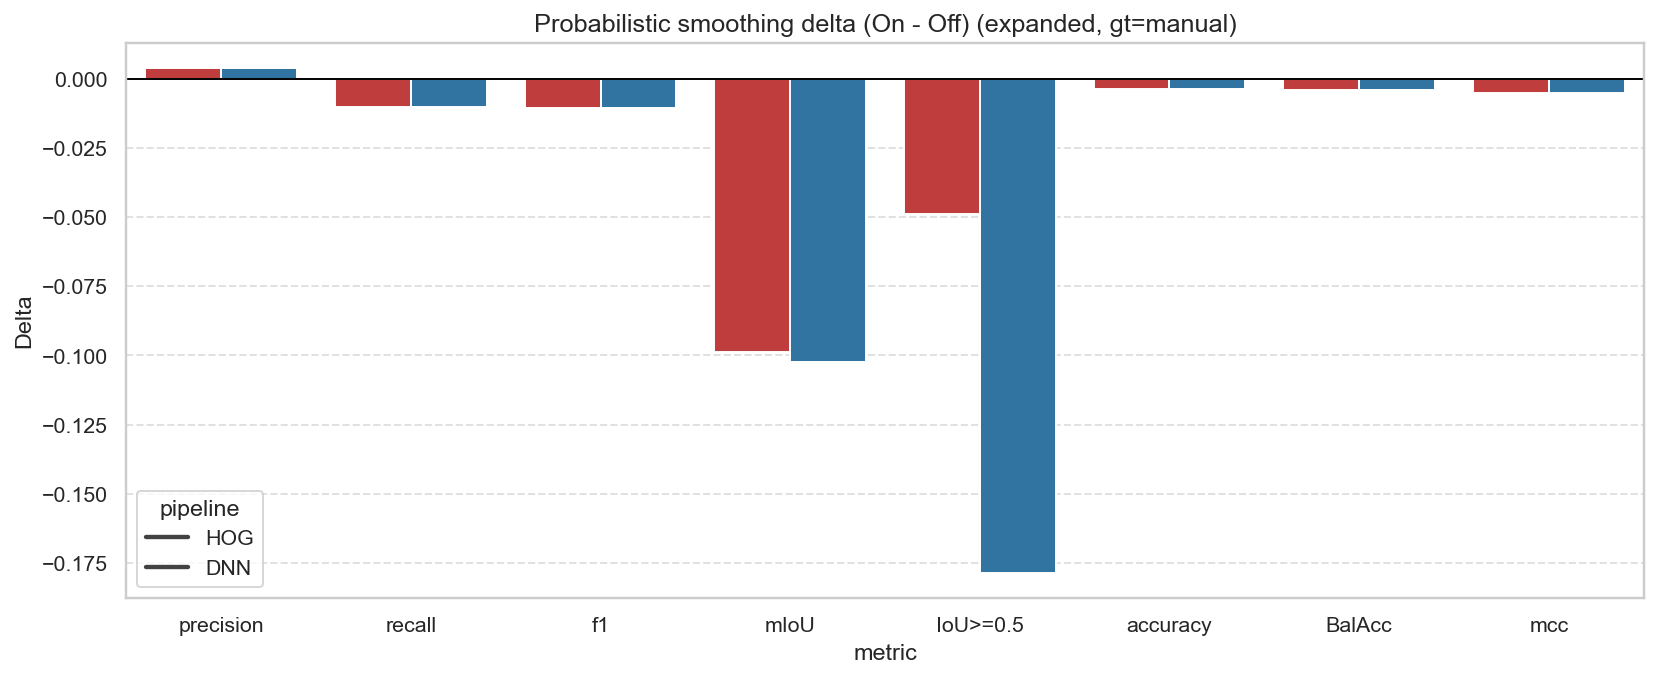

In [9]:
def plot_prob_smoothing_deltas(*, split: str, gt: str = "manual") -> Path:
    base = df[(df["gt"] == gt) & (df["split"] == split) & (df["pipeline"].isin(["hog", "dnn"]))]

    off = base[base["prob"] == "off"].set_index("pipeline")
    on = base[base["prob"] == "on"].set_index("pipeline")

    assert set(off.index) == {"hog", "dnn"}
    assert set(on.index) == {"hog", "dnn"}

    metrics = ["precision", "recall", "f1", "mean_iou", "iou_ge_0_5", "accuracy", "balanced_accuracy", "mcc"]

    deltas = []
    for pipeline in ["hog", "dnn"]:
        for metric in metrics:
            deltas.append(
                {
                    "pipeline": pipeline,
                    "metric": metric,
                    "delta": float(on.loc[pipeline, metric]) - float(off.loc[pipeline, metric]),
                }
            )

    ddf = pd.DataFrame(deltas)
    ddf["metric"] = ddf["metric"].replace(
        {
            "mean_iou": "mIoU",
            "iou_ge_0_5": "IoU>=0.5",
            "balanced_accuracy": "BalAcc",
        }
    )

    fig, ax = plt.subplots(figsize=(12, 5))
    sns.barplot(
        data=ddf,
        x="metric",
        y="delta",
        hue="pipeline",
        palette={"hog": "#d62728", "dnn": "#1f77b4"},
        ax=ax,
    )
    ax.axhline(0, color="black", linewidth=1)
    ax.set_title(f"Probabilistic smoothing delta (On - Off) ({split}, gt={gt})", fontsize=13)
    ax.set_ylabel("Delta")
    ax.grid(axis="y", linestyle="--", alpha=0.6)
    ax.legend(title="pipeline", labels=["HOG", "DNN"])

    return savefig(fig, f"prob_smoothing_deltas_{split}_{gt}")


plot_prob_smoothing_deltas(split="expanded", gt="manual")
plt.show()


Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\auto_detectors_vs_manual_expanded.png
Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\auto_detectors_vs_manual_expanded.svg


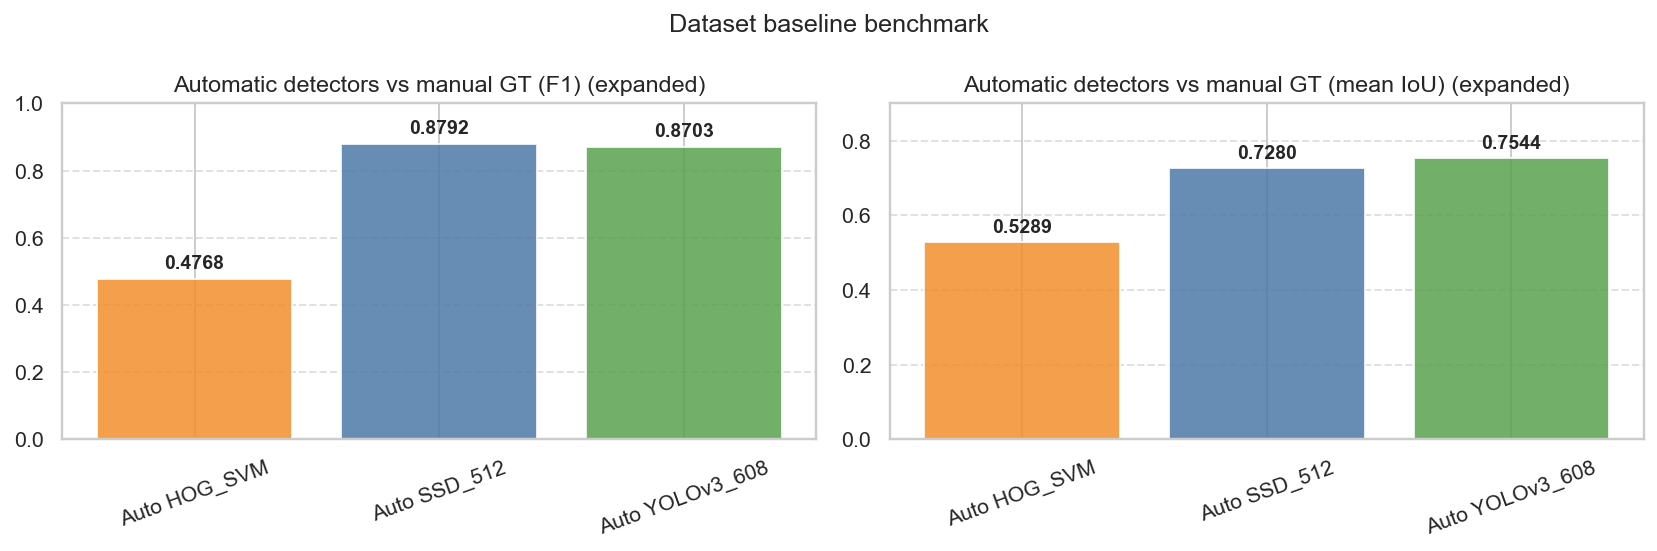

In [10]:
def plot_auto_detectors_vs_manual(*, split: str = "expanded") -> Path:
    sub = df[(df["gt"] == "manual") & (df["split"] == split) & (df["pipeline"].isin(["auto_hogsvm", "auto_ssd512", "auto_yolov3"]))]
    assert len(sub) == 3

    sub = sub.copy()
    sub["display"] = sub["pipeline"].map(
        {
            "auto_hogsvm": "Auto HOG_SVM",
            "auto_ssd512": "Auto SSD_512",
            "auto_yolov3": "Auto YOLOv3_608",
        }
    )

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    bars1 = axes[0].bar(sub["display"], sub["f1"], alpha=0.85, color=["#f28e2b", "#4e79a7", "#59a14f"])
    axes[0].set_title(f"Automatic detectors vs manual GT (F1) ({split})")
    axes[0].set_ylim(0, 1.0)
    axes[0].grid(axis="y", linestyle="--", alpha=0.6)
    axes[0].tick_params(axis="x", rotation=20)
    _label_bars(axes[0], bars1, pad=0.02)

    bars2 = axes[1].bar(sub["display"], sub["mean_iou"], alpha=0.85, color=["#f28e2b", "#4e79a7", "#59a14f"])
    axes[1].set_title(f"Automatic detectors vs manual GT (mean IoU) ({split})")
    axes[1].set_ylim(0, 0.9)
    axes[1].grid(axis="y", linestyle="--", alpha=0.6)
    axes[1].tick_params(axis="x", rotation=20)
    _label_bars(axes[1], bars2, pad=0.015)

    fig.suptitle("Dataset baseline benchmark", fontsize=13)
    return savefig(fig, f"auto_detectors_vs_manual_{split}")


plot_auto_detectors_vs_manual(split="expanded")
plt.show()


Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\presence_timeline_video4_1_hog.png
Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\presence_timeline_video4_1_hog.svg


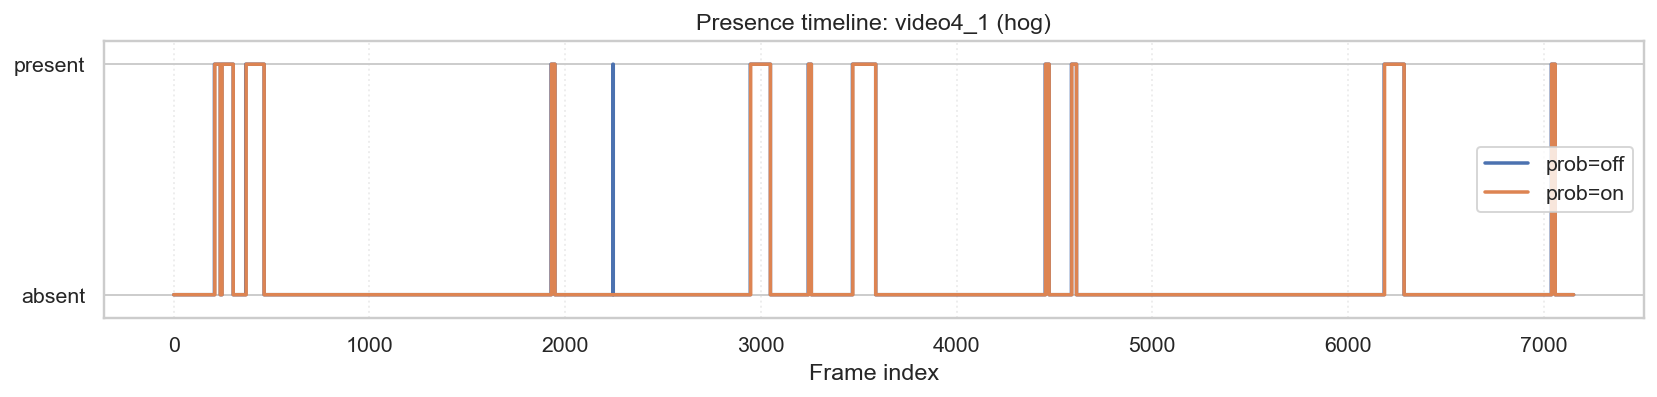

In [11]:
def load_predictions_presence(pred_path: Path) -> np.ndarray:
    payload = json.loads(pred_path.read_text(encoding="utf-8"))
    frames = payload.get("frames", [])
    presence = np.zeros(len(frames), dtype=np.int8)
    for i, fr in enumerate(frames):
        dets = fr.get("detections", [])
        presence[i] = 1 if dets else 0
    return presence


def plot_presence_timeline(*, video_stem: str = "video4_1", detector: str = "hog") -> Path:
    # detector: 'hog' or 'dnn'
    pred_dir = EVALUATIONS_DIR / "predictions" / detector
    pred_prob_dir = EVALUATIONS_DIR / "predictions_prob" / detector

    base_path = pred_dir / f"{video_stem}.json"
    prob_path = pred_prob_dir / f"{video_stem}.json"

    assert base_path.exists(), f"Missing prediction: {base_path}"
    assert prob_path.exists(), f"Missing prob prediction: {prob_path}"

    base = load_predictions_presence(base_path)
    prob = load_predictions_presence(prob_path)

    x = np.arange(len(base))

    fig, ax = plt.subplots(figsize=(12, 3))
    ax.step(x, base, where="post", label="prob=off", linewidth=1.8)
    ax.step(x, prob, where="post", label="prob=on", linewidth=1.8)

    ax.set_ylim(-0.1, 1.1)
    ax.set_yticks([0, 1], ["absent", "present"])
    ax.set_xlabel("Frame index")
    ax.set_title(f"Presence timeline: {video_stem} ({detector})")
    ax.grid(axis="x", linestyle=":", alpha=0.35)
    ax.legend()

    return savefig(fig, f"presence_timeline_{video_stem}_{detector}")


plot_presence_timeline(video_stem="video4_1", detector="hog")
plt.show()


Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\iou_comparison_expanded_manual_prob_off.png
Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\iou_comparison_expanded_manual_prob_off.svg
Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\iou_comparison_option_a_manual_prob_off.png
Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\iou_comparison_option_a_manual_prob_off.svg
Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\prf1_expanded_manual_prob_off.png
Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\prf1_expanded_manual_prob_off.svg
Wrote: e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\localisation_miou_expanded_manual_prob_off.png
Wrote: e:\22837352\Media-Technology-Module\c

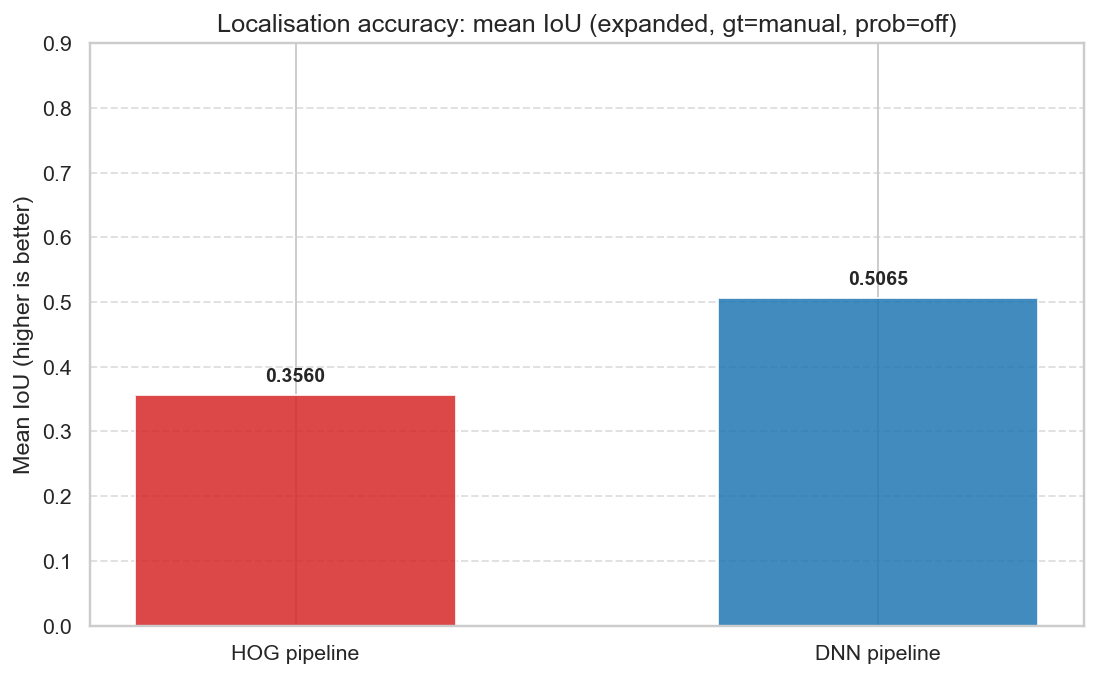

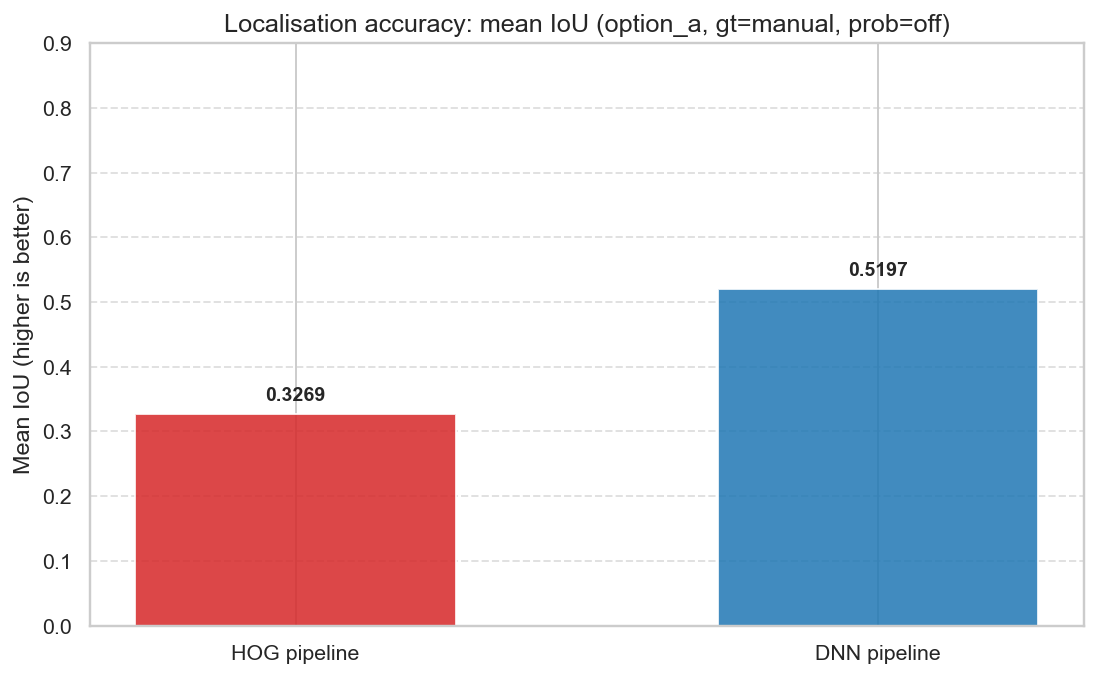

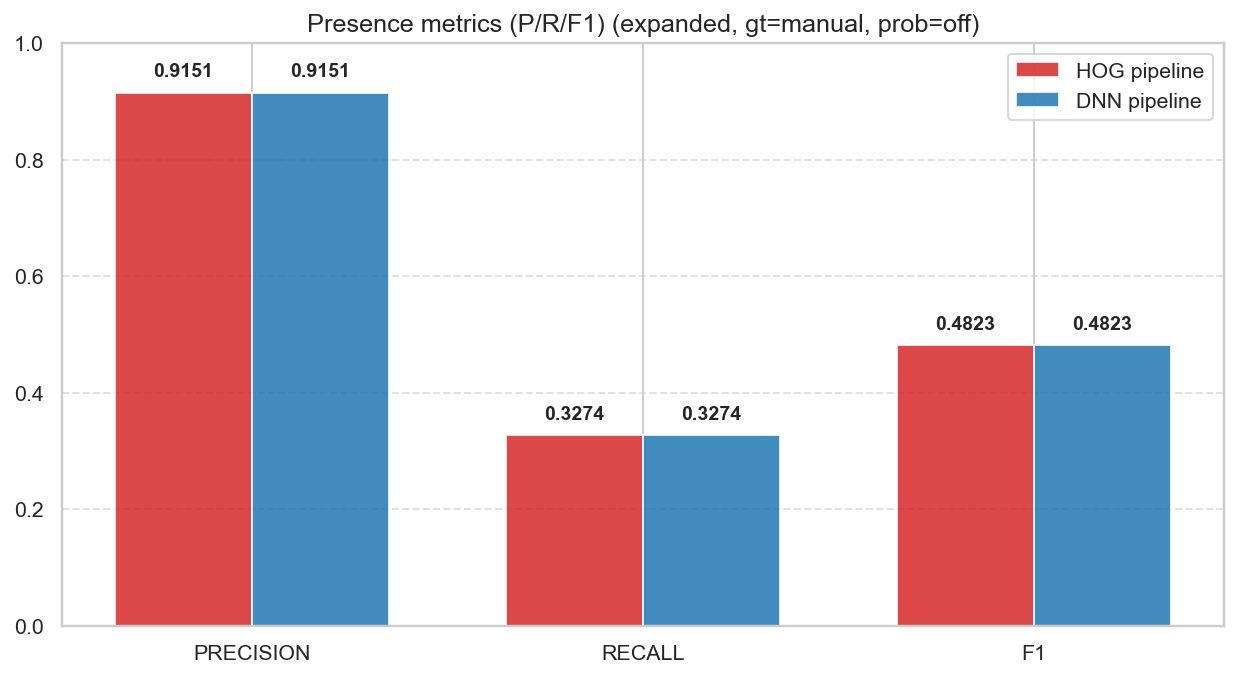

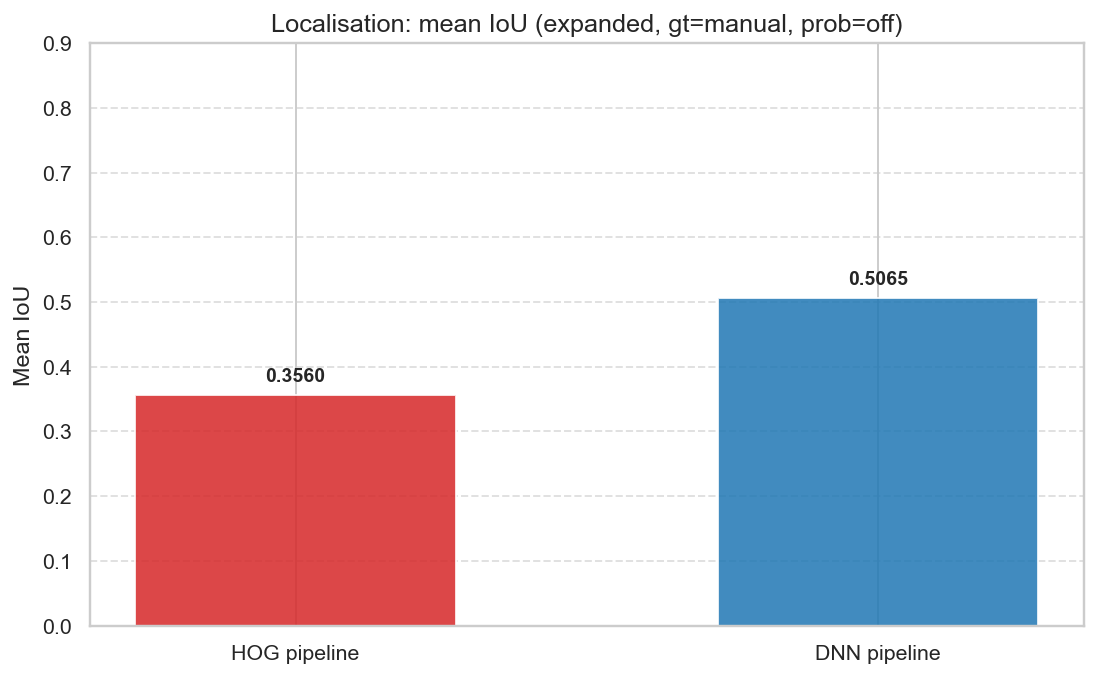

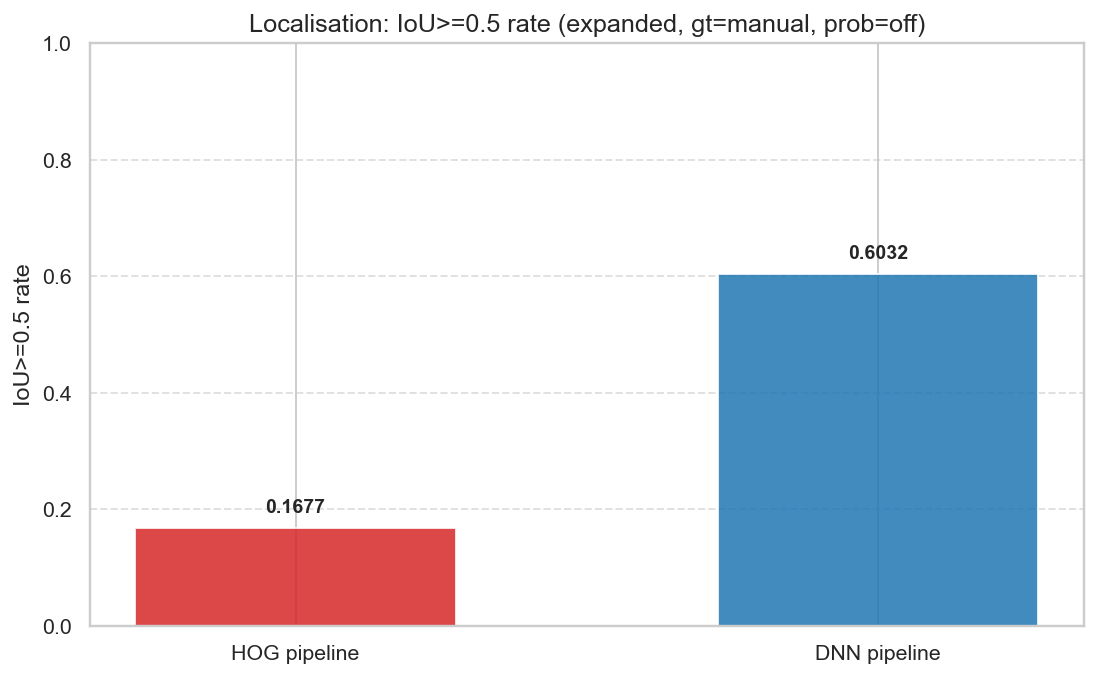

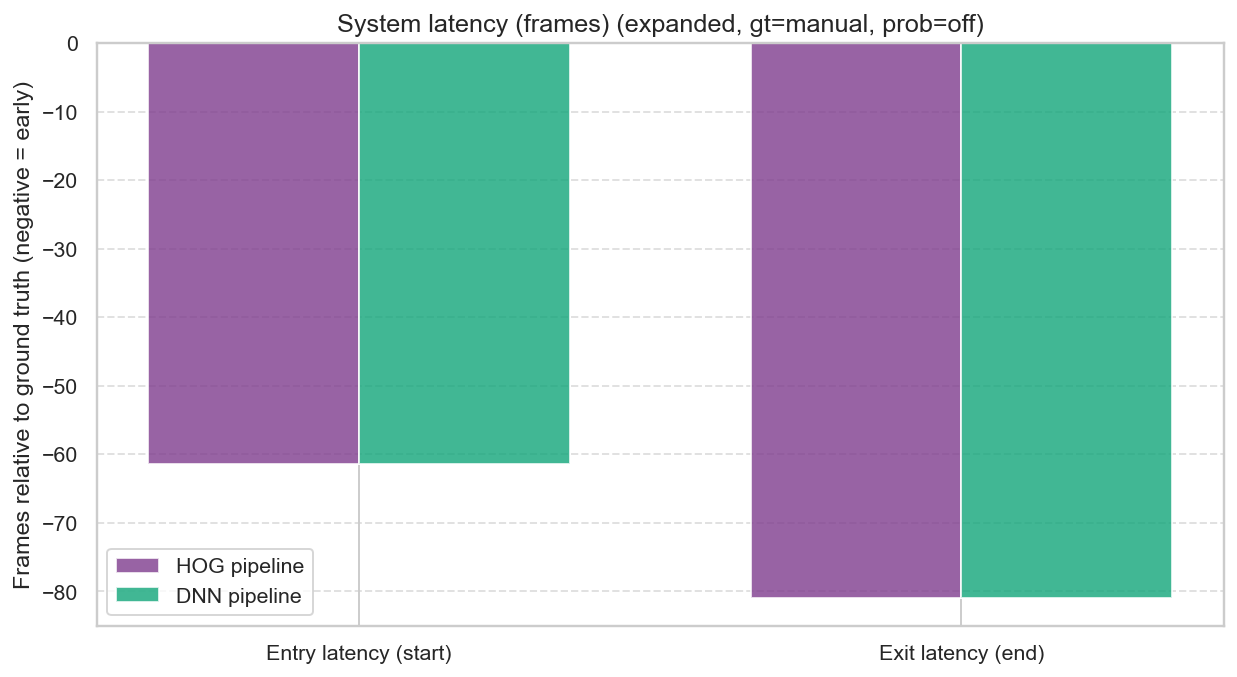

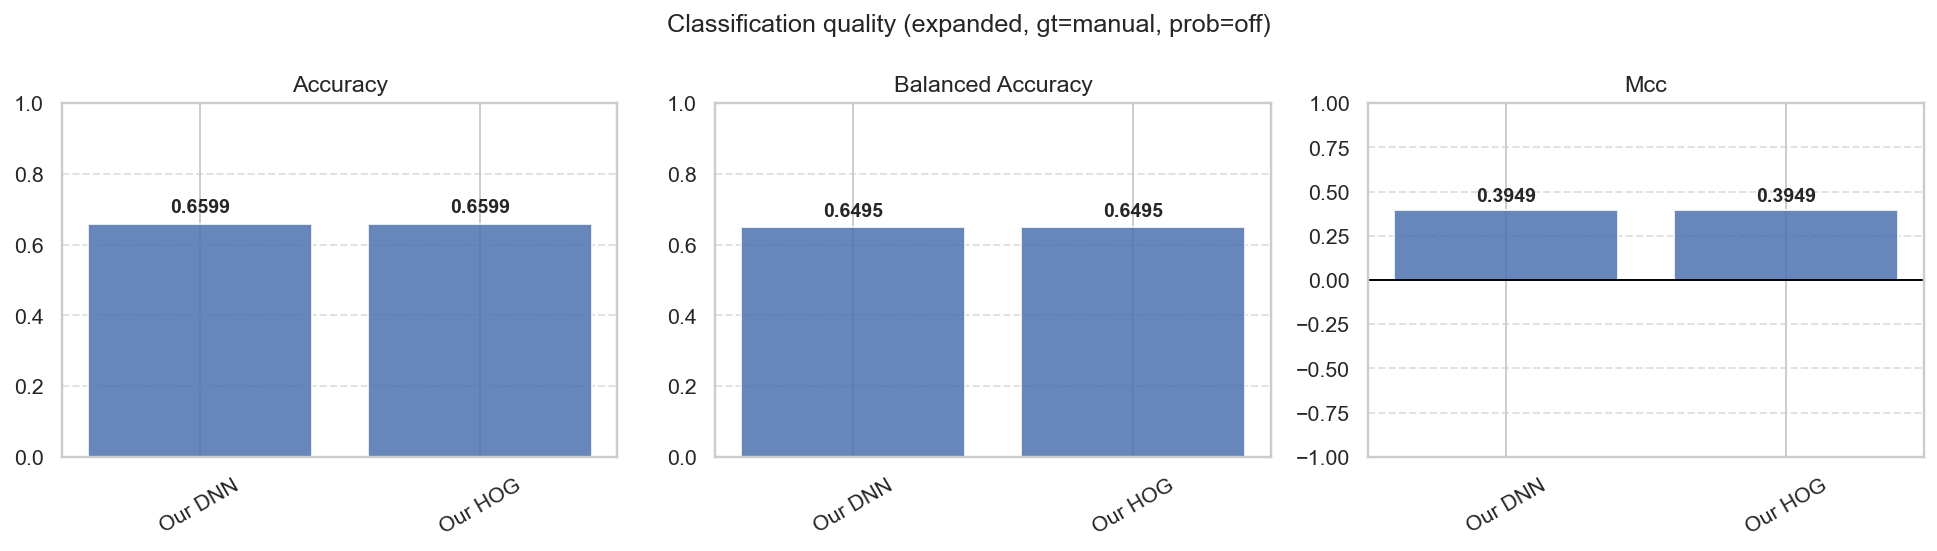

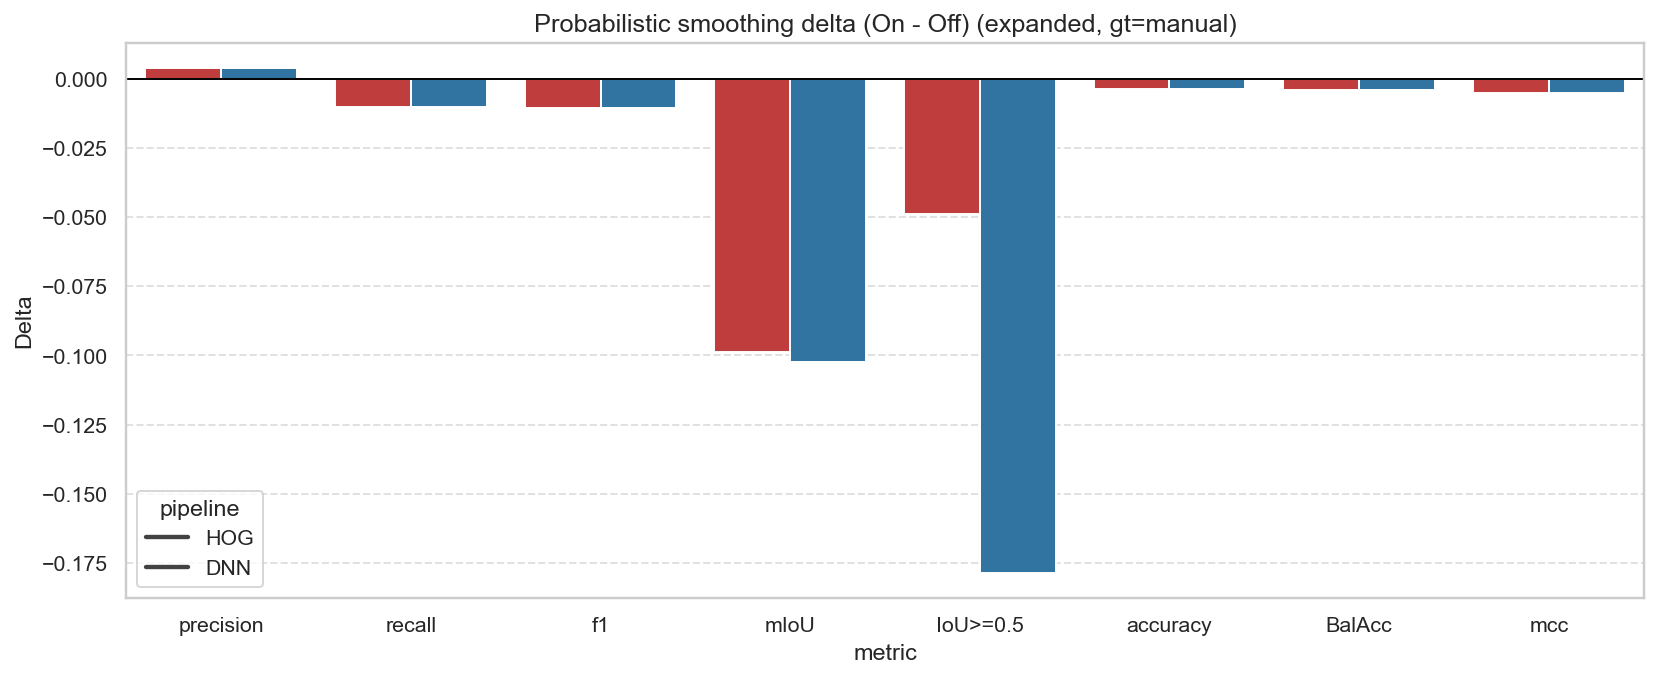

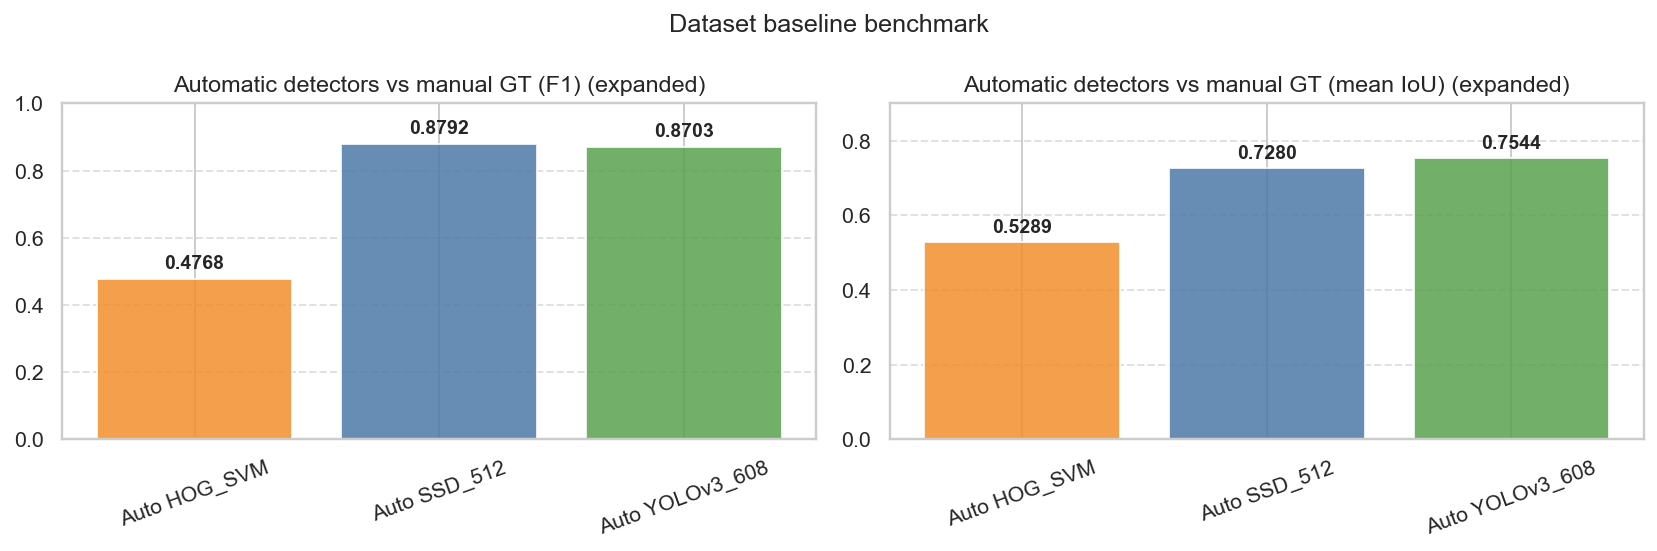

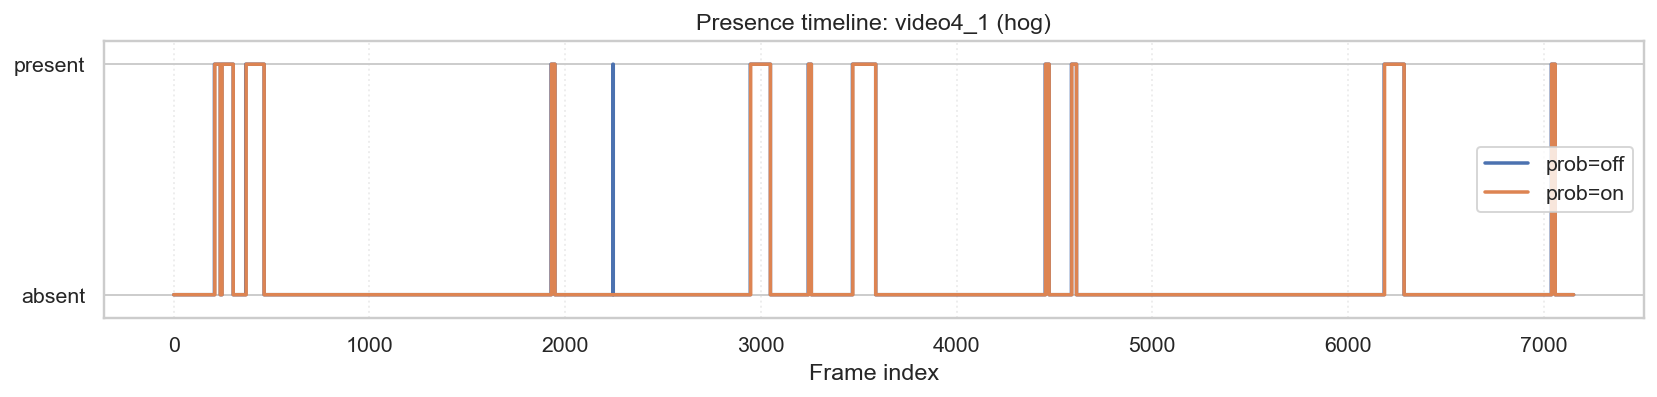


Generated files:
- e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\iou_comparison_expanded_manual_prob_off.png
- e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\iou_comparison_option_a_manual_prob_off.png
- e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\prf1_expanded_manual_prob_off.png
- e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\localisation_miou_expanded_manual_prob_off.png
- e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\localisation_iou05_expanded_manual_prob_off.png
- e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\latency_expanded_manual_prob_off.png
- e:\22837352\Media-Technology-Module\csy3058_as2_smart_security_camera\evaluations\plots\quality_expanded_manual_prob_off.png
- e:\22837352\Media-Technology-Module\csy3058_as2_smart_secur

[WindowsPath('e:/22837352/Media-Technology-Module/csy3058_as2_smart_security_camera/evaluations/plots/iou_comparison_expanded_manual_prob_off.png'),
 WindowsPath('e:/22837352/Media-Technology-Module/csy3058_as2_smart_security_camera/evaluations/plots/iou_comparison_option_a_manual_prob_off.png'),
 WindowsPath('e:/22837352/Media-Technology-Module/csy3058_as2_smart_security_camera/evaluations/plots/prf1_expanded_manual_prob_off.png'),
 WindowsPath('e:/22837352/Media-Technology-Module/csy3058_as2_smart_security_camera/evaluations/plots/localisation_miou_expanded_manual_prob_off.png'),
 WindowsPath('e:/22837352/Media-Technology-Module/csy3058_as2_smart_security_camera/evaluations/plots/localisation_iou05_expanded_manual_prob_off.png'),
 WindowsPath('e:/22837352/Media-Technology-Module/csy3058_as2_smart_security_camera/evaluations/plots/latency_expanded_manual_prob_off.png'),
 WindowsPath('e:/22837352/Media-Technology-Module/csy3058_as2_smart_security_camera/evaluations/plots/quality_expand

In [12]:
def regenerate_all_plots() -> list[Path]:
    written: list[Path] = []

    # Manual GT core plots
    written.append(plot_iou_comparison(split="expanded", prob="off", gt="manual"))
    written.append(plot_iou_comparison(split="option_a", prob="off", gt="manual"))
    written.append(plot_prf1_grouped(split="expanded", prob="off", gt="manual"))
    written.extend(list(plot_localisation_pair(split="expanded", prob="off", gt="manual")))
    written.append(plot_latency(split="expanded", prob="off", gt="manual"))

    # Extras
    written.append(plot_quality_metrics(split="expanded", prob="off", gt="manual"))
    written.append(plot_prob_smoothing_deltas(split="expanded", gt="manual"))
    written.append(plot_auto_detectors_vs_manual(split="expanded"))

    # Optional timeline plot (example)
    written.append(plot_presence_timeline(video_stem="video4_1", detector="hog"))

    plt.show()

    print("\nGenerated files:")
    for p in written:
        print("-", p)

    return written


regenerate_all_plots()
